# Classification: premier modèle avec les SVM

Lino Galiana  
2024-09-23

Ce chapitre utilise toujours le même jeu de données, présenté dans l’[introduction
de cette partie](index.qmd) : les données de vote aux élections présidentielles américaines
croisées à des variables sociodémographiques.
Le code
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/main/content/modelisation/get_data.py).

In [1]:
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas

In [2]:
import requests

url = "https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py"
r = requests.get(url, allow_redirects=True)
open("getdata.py", "wb").write(r.content)

import getdata

votes = getdata.create_votes_dataframes()


Pour ce TP, nous aurons besoin des packages suivants :

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


## 0.1 La méthode des *SVM* (*Support Vector Machines*)

L’une des méthodes de *machine learning* les
plus utilisées en classification sont les SVM (*Support Vector Machines*).
Il s’agit de trouver, dans un système de projection adéquat (noyau ou *kernel*),
les paramètres de l’hyperplan (en fait d’un hyperplan à marges maximales)
séparant les classes de données :

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png)

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Formalisation mathématique</h3>

Les SVM sont l’une des méthodes de *machine learning* les plus intuitives
du fait de l’interprétation géométrique simple de la méthode. Il s’agit
aussi d’un des algorithmes de *machine learning* à la formalisation
la moins complexe pour les praticiens ayant des notions en statistique
traditionnelle. Cette boîte revient dessus. Néanmoins,
celle-ci n’est pas nécessaire à la compréhension du chapitre.
En *machine learning*, plus que les détails mathématiques, l’important
est d’avoir des intuitions.

L’objectif des SVM est, rappelons-le, de trouver un hyperplan qui permette
de séparer les différentes classes au mieux. Par exemple, dans un espace
à deux dimensions, il s’agit de trouver une droite avec des marges
qui permette de séparer au mieux l’espace en partie avec
des *labels* homogènes.

On peut, sans perdre de généralité,
supposer que le problème consiste à supposer l’existence d’une loi de probabilité $\mathbb{P}(x,y)$ ($\mathbb{P} \to \{-1,1\}$) qui est inconnue. Le problème de discrimination
vise à construire un estimateur de la fonction de décision idéale qui minimise la probabilité d’erreur, autrement dit

$$
\theta = \arg\min_\Theta \mathbb{P}(h_\theta(X) \neq y |x)
$$

Les SVM les plus simples sont les SVM linéaires. Dans ce cas, on suppose qu’il existe un séparateur linéaire qui permet d’associer chaque classe à son signe:

$$
h_\theta(x) = \text{signe}(f_\theta(x)) ; \text{ avec } f_\theta(x) = \theta^T x + b
$$
avec $\theta \in \mathbb{R}^p$ et $w \in \mathbb{R}$.

![](https://upload.wikimedia.org/wikipedia/commons/7/72/SVM_margin.png)

Lorsque des observations sont linéairement séparables,
il existe une infinité de frontières de décision linéaire séparant les deux classes. Le *“meilleur”* choix est de prendre la marge maximale permettant de séparer les données. La distance entre les deux marges est $\frac{2}{||\theta||}$. Donc maximiser cette distance entre deux hyperplans revient à minimiser $||\theta||^2$ sous la contrainte $y_i(\theta^Tx_i + b) \geq 1$.

Dans le cas non linéairement séparable, la *hinge loss* $\max\big(0,y_i(\theta^Tx_i + b)\big)$ permet de linéariser la fonction de perte:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Hinge_loss_vs_zero_one_loss.svg/1024px-Hinge_loss_vs_zero_one_loss.svg.png)

ce qui donne le programme d’optimisation suivant :

$$
\frac{1}{n} \sum_{i=1}^n \max\big(0,y_i(\theta^Tx_i + b)\big) + \lambda ||\theta||^2
$$

La généralisation au cas non linéaire implique d’introduire des noyaux transformant l’espace de coordonnées des observations.

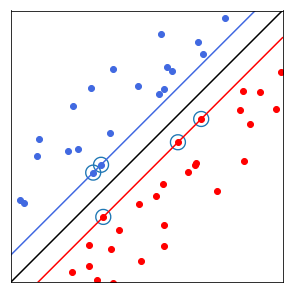

</div>

## 0.2 Application

Pour appliquer un modèle de classification, il nous faut
trouver une variable dichotomique. Le choix naturel est
de prendre la variable dichotomique qu’est la victoire ou
défaite d’un des partis.

Même si les Républicains ont perdu en 2020, ils l’ont emporté
dans plus de comtés (moins peuplés). Nous allons considérer
que la victoire des Républicains est notre *label* 1 et la défaite *0*.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1 : Premier algorithme de classification</h3>

1.  Créer une variable *dummy* appelée `y` dont la valeur vaut 1 quand les républicains l’emportent.
2.  En utilisant la fonction prête à l’emploi nommée `train_test_split` de la librairie `sklearn.model_selection`,
    créer des échantillons de test (20 % des observations) et d’estimation (80 %) avec comme *features* : `'Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"` et comme *label* la variable `y`.

*Note: Il se peut que vous ayez le warning suivant :*

> A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

*Note : Pour éviter ce warning à chaque fois que vous estimez votre modèle, vous pouvez utiliser `DataFrame[['y']].values.ravel()` plutôt que `DataFrame[['y']]` lorsque vous constituez vos échantillons.*

1.  Entraîner un classifieur SVM avec comme paramètre de régularisation `C = 1`. Regarder les mesures de performance suivante : `accuracy`, `f1`, `recall` et `precision`.

2.  Vérifier la matrice de confusion : vous devriez voir que malgré des scores en apparence pas si mauvais, il y a un problème notable.

3.  Refaire les questions précédentes avec des variables normalisées. Le résultat est-il différent ?

4.  Changer de variables *x*. Utiliser uniquement le résultat passé du vote démocrate (année 2016) et le revenu. Les variables en question sont `share_2016_republican` et `Median_Household_Income_2019`. Regarder les résultats, notamment la matrice de confusion.

5.  \[OPTIONNEL\] Faire une 5-fold validation croisée pour déterminer le paramètre *C* idéal.

</div>

A l’issue de la question 3,
le classifieur avec `C = 1`
devrait avoir les performances suivantes :

|           |    Score |
|:----------|---------:|
| Accuracy  | 0.882637 |
| Recall    | 0.897297 |
| Precision | 0.968872 |
| F1        | 0.931712 |

La matrice de confusion associée
prend cette forme:

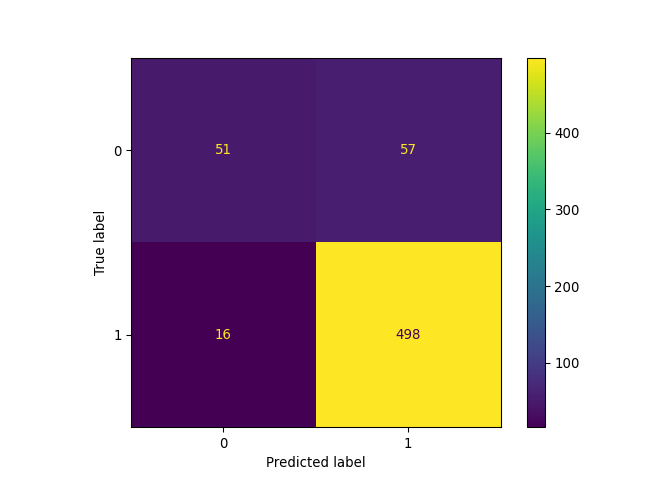

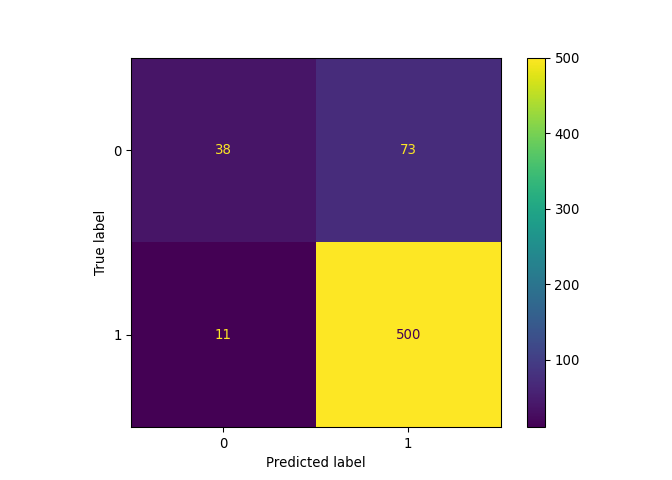

A l’issue de la question 6,
le nouveau classifieur avec devrait avoir les performances suivantes :

|           |    Score |
|:----------|---------:|
| Accuracy  | 0.882637 |
| Recall    | 0.897297 |
| Precision | 0.968872 |
| F1        | 0.931712 |

Et la matrice de confusion associée :

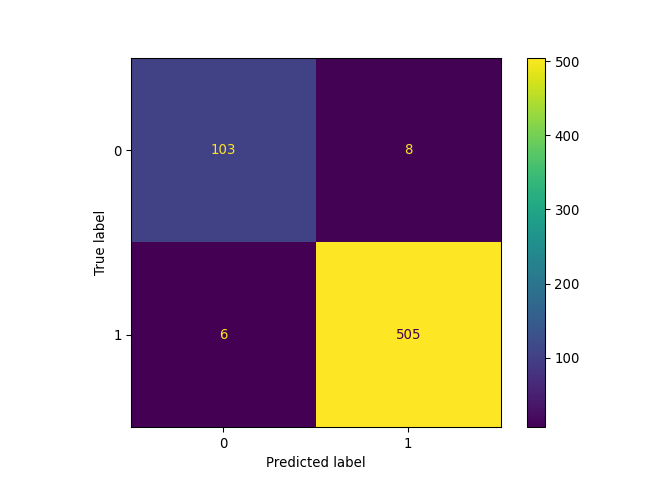